In [2]:
import re

# Clean text
def clean_text(text):
    # Remove patterns at beginning of text such as "WASHINGTON (Reuters) -"
    # cleaned_text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    # cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)
    cleaned_text = re.sub(r"^\S+(?:\s+\S+)*\s*\([^)]+\)\s*-", '', str(text))
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)
    # cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', cleaned_text)
    # cleaned_text = re.sub(r',+', ' ', cleaned_text)

    return cleaned_text.lower()

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import shuffle


# df = pd.read_csv('labeled_fulldata.csv')
# df = pd.read_csv('preprocessed_welfake.csv')
df = pd.read_csv('WELFake_Dataset.csv')

# df = df.sample(frac=1, random_state=42)
#df = df[0:25000]  
df['text'] = df['text'].apply(clean_text)
df.dropna(subset=['title'], inplace=True)
df.dropna(subset=['text'], inplace=True)
df['fake_news_flag'] = df['label']
df.drop(columns=["Unnamed: 0", "label"], inplace= True)
true_df = pd.read_csv('True.csv')
false_df = pd.read_csv('Fake.csv')
 
true_df["fake_news_flag"] = 0

true_df['text'] = true_df['text'].apply(clean_text)
false_df["fake_news_flag"] = 1

combined_df = pd.concat([true_df, false_df], ignore_index=True)
df = pd.concat([combined_df, df], ignore_index=True)
df


,title,text,subject,date,fake_news_flag
0,"As U.S. budget fight looms, Republicans flip t...",the head of a conservative republican faction...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,the special counsel investigation of links be...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,trump campaign adviser george papadopoulos to...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,president donald trump called on the us posta...,politicsNews,"December 29, 2017",0
...,...,...,...,...,...
116469,Russians steal research on Trump in hack of U....,hackers believed to be working for the russia...,NaN,NaN,0
116470,WATCH: Giuliani Demands That Democrats Apolog...,you know because in fantasyland republicans ne...,NaN,NaN,1
116471,Migrants Refuse To Leave Train At Refugee Camp...,migrants refuse to leave train at refugee camp...,NaN,NaN,0
116472,Trump tussle gives unpopular Mexican leader mu...,donald trumps combative style has buffeted me...,NaN,NaN,0


In [4]:

X = df['text']  
#df['fake_news_flag']  = df['label']
y = df['fake_news_flag']  # Labels (0: real, 1: fake)
vectorizer=TfidfVectorizer()
vectorizer.fit(X)
X=vectorizer.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=42)


In [ ]:
model = LogisticRegression() 
model.fit(X_train, y_train)  

y_pred = model.predict(X_test)


In [ ]:
print(y_test, y_pred)
# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Testing new predictions
new_text = ["Dem senator says Abrego Garcia situation 'not going to end well' for Trump, argues he's 'undermining' freedom. White House blasts Dems for wanting to die on a hill defending 'a violent illegal alien, wifebeater, and foreign terrorist'"]
new_text_tfidf = vectorizer.transform(new_text)
prediction = model.predict(new_text_tfidf)

print(f"Prediction (0: real, 1: fake): {prediction[0]}")


64612     1
7273      0
30551     1
41042     1
53840     0
         ..
111084    1
25806     1
10380     0
22472     1
89527     1
Name: fake_news_flag, Length: 34943, dtype: int64 [1 0 1 ... 0 1 1]
Accuracy: 0.9647998168445755
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     16934
           1       0.96      0.97      0.97     18009

    accuracy                           0.96     34943
   macro avg       0.96      0.96      0.96     34943
weighted avg       0.96      0.96      0.96     34943

Prediction (0: real, 1: fake): 1


In [ ]:
#new_text_tfidf = X_test[1]
#new_text_tfidf = vectorizer.transform(["Defense Secretary Pete Hegseth boasted on social media Tuesday that he had dismantled a program supporting women on security teams, an initiative that he called “woke” but actually was signed into law by his boss, President Donald Trump."])
new_text_tfidf = vectorizer.transform(["A newly leaked internal memo from an international climate research organization allegedly suggests discrepancies in the global temperature data used in major climate models. Though the details remain vague, some independent analysts claim the memo hints at deliberate misrepresentation to exaggerate warming trends. The institution in question has not issued a formal response."])
feature_names = vectorizer.get_feature_names_out()
coeffs = model.coef_[0]  

vec_indices = new_text_tfidf.nonzero()[1]
word_contributions = [(feature_names[i], new_text_tfidf[0, i] * coeffs[i]) for i in vec_indices]

word_contributions_sorted = sorted(word_contributions, key=lambda x: -abs(x[1]))

print(f"\nPredicted: {'Fake' if model.predict(new_text_tfidf)[0] == 1 else 'Real'}")
print("\nTop influential words:")
for word, impact in word_contributions_sorted[:10]:
    direction = "Fake" if impact > 0 else "Real"
    print(f"{word:<20} => {impact:+.4f} ({direction})")

print(y_test)


Predicted: Fake

Top influential words:
in                   => -0.5601 (Real)
memo                 => +0.1984 (Fake)
data                 => -0.1649 (Real)
global               => +0.1408 (Fake)
some                 => -0.1297 (Real)
an                   => -0.1219 (Real)
at                   => -0.1191 (Real)
internal             => +0.1093 (Fake)
leaked               => +0.0843 (Fake)
formal               => -0.0785 (Real)
64612     1
7273      0
30551     1
41042     1
53840     0
         ..
111084    1
25806     1
10380     0
22472     1
89527     1
Name: fake_news_flag, Length: 34943, dtype: int64


/Users/jasperhoong/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jasperhoong/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

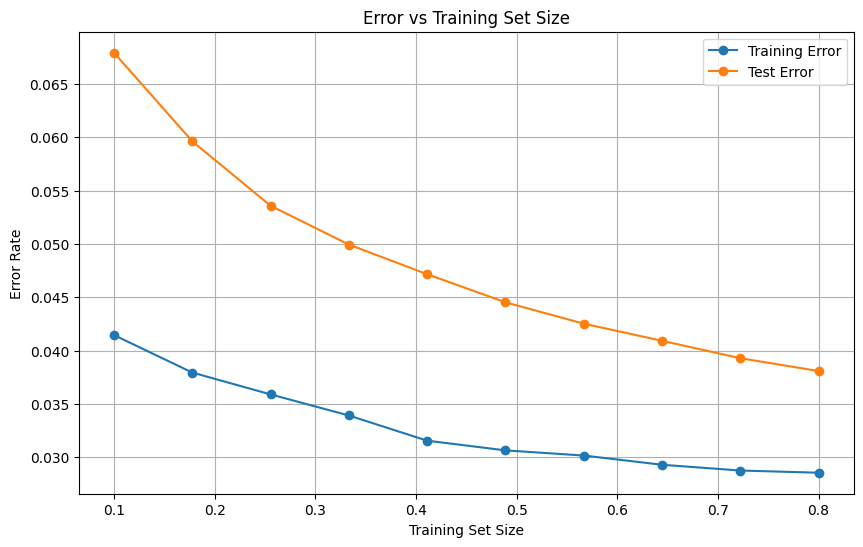

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


training_set_sizes = np.linspace(0.1, 0.8, 10) 
train_errors = []
test_errors = []

for train_size in training_set_sizes:
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=train_size, random_state=42)

    model = LogisticRegression()
    model.fit(X_train_subset, y_train_subset)
    
    train_pred = model.predict(X_train_subset)
    test_pred = model.predict(X_test)
    
    train_error = 1 - accuracy_score(y_train_subset, train_pred)
    test_error = 1 - accuracy_score(y_test, test_pred)
    
    train_errors.append(train_error)
    test_errors.append(test_error)

# Plot 
plt.figure(figsize=(10, 6))
plt.plot(training_set_sizes, train_errors, label="Training Error", marker='o')
plt.plot(training_set_sizes, test_errors, label="Test Error", marker='o')
plt.xlabel("Training Set Size")
plt.ylabel("Error Rate")
plt.title("Error vs Training Set Size")
plt.legend()
plt.grid(True)
plt.show()